# Import thư viện


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu vào DataFrame
df_t_2 = pd.read_csv(r'E:\CoChau\Fair_2024_LSTM_GA-LSTM_BiLSTM_GA-BiLSTM\Code\data\data_t_2\TongMua_KaNak_AnKhe_t-2.csv')
df_t_4 = pd.read_csv(r'E:\CoChau\Fair_2024_LSTM_GA-LSTM_BiLSTM_GA-BiLSTM\Code\data\data_t_4\TongMua_KaNak_AnKhe_t-4.csv')
df_t_6 = pd.read_csv(r'E:\CoChau\Fair_2024_LSTM_GA-LSTM_BiLSTM_GA-BiLSTM\Code\data\data_t_6\TongMua_KaNak_AnKhe_t-6.csv')
df_t_8 = pd.read_csv(r'E:\CoChau\Fair_2024_LSTM_GA-LSTM_BiLSTM_GA-BiLSTM\Code\data\data_t_8\TongMua_KaNak_AnKhe_t-8.csv')

# Xử lý dữ liệu bị thiếu
df_t_2 = df_t_2.dropna()
df_t_4 = df_t_4.dropna()
df_t_6 = df_t_6.dropna()
df_t_8 = df_t_8.dropna()

# Tạo dữ liệu huấn luyện

In [3]:
def create_dataset(X, y, n_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i+n_steps])
    return np.array(Xs), np.array(ys)

# Chuẩn hóa và chia bộ dữ liệu cho mô hình LSTM

In [4]:
# Chuẩn hóa dữ liệu
def scaler(df, time_steps):
    scaler = MinMaxScaler()
    X = df[['Tổng lưu lượng xả (m³/s)[Thực tế]', 'Lưu lượng đến hồ (m³/s)', 'Sum_Mua']]
    y = df[['Lưu lượng đến hồ (m³/s)']]
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    # Tạo nhãn cho dữ liệu
    X_data, y_data = create_dataset(X, y, time_steps)

    return scaler, X_data, y_data

In [5]:
# Chuẩn hóa dữ liệu
def split_data(X_data, y_data, time_steps):
    # Chia dữ liệu thành tập huấn luyện, kiểm tra và test
    train_length = int(len(X_data) * 0.7)
    val_length = int((len(X_data) - train_length) / 2)

    X_train, y_train = X_data[:train_length], y_data[:train_length]
    X_val, y_val = X_data[train_length:train_length+val_length], y_data[train_length:train_length+val_length]
    X_test, y_test = X_data[-val_length:], y_data[-val_length:]

    # Reshape dữ liệu đầu vào
    X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[2])
    X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[2])
    X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[2])

    print("Kích thước X_train:", X_train.shape)
    print("Kích thước X_val:", X_val.shape)
    print("Kích thước X_test:", X_test.shape)
    print("Kích thước y_train:", y_train.shape)
    print("Kích thước y_val:", y_val.shape)
    print("Kích thước y_test:", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Xây dựng mô hình LSTM

In [6]:
def train_model(X_train, y_train, X_val, y_val, epochs, batch_size, save_best_model):
    # Xác định kích thước đầu vào và xây dựng mô hình GRU
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, activation='tanh', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.summary()

    # Compile mô hình
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    # Lưu lại model tốt nhất
    model_checkpoint = ModelCheckpoint(save_best_model, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=model_checkpoint)
    
    return model, history

In [7]:
import matplotlib.pyplot as plt

def plot_loss_model(history):
    # Trích xuất giá trị loss trên tập huấn luyện và kiểm tra
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, linestyle='-', label='Train loss')
    plt.plot(val_loss, linestyle='-', label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train loss and Val loss')
    plt.yscale('log')  # Scale y-axis to logarithmic scale
    plt.legend()  # Thêm nhãn chú thích
    plt.show()

# Dự đoán trên tập kiểm tra và tính toán các chỉ số

In [8]:
def evaluate(model, X_test, y_test):
    # Dự đoán trên tập validation
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = sqrt(mse_test)
    rmae_test = sqrt(mae_test)

    # Print evaluation results
    print("Mean Squared Error (MSE) on test set:", mse_test)
    print("Mean Absolute Error (MAE) on test set:", mae_test)
    print("R-squared (R2) on test set:", r2_test)
    print("Root Mean Squared Error (RMSE) on test set:", rmse_test)
    print("Root Mean Absolute Error (RMAE) on test set:", rmae_test)

    return y_pred

# Hiển thị biểu đồ kết quả

In [9]:
# Khôi phục dữ liệu sau chuẩn hóa
def inverse_transform_data(scaler, y_pred, y_test):
    y_pred_predict = scaler.inverse_transform(y_pred)
    y_pred_predict = pd.DataFrame(y_pred_predict)

    y_test = scaler.inverse_transform(y_test)
    y_test = pd.DataFrame(y_test)

    return y_pred_predict, y_test

In [10]:
def plot_data_goc(df):
    # Vẽ biểu đồ dữ liệu gốc
    plt.figure(figsize=(15, 6))
    plt.plot(df['thoi_gian_KaNak'], df['Tổng lưu lượng xả (m³/s)[Thực tế]'], label='Tổng lưu lượng xả')
    plt.plot(df['thoi_gian_KaNak'], df['Lưu lượng đến hồ (m³/s)'], label='Lưu lượng đến hồ')
    plt.plot(df['thoi_gian_KaNak'], df['Sum_Mua'], label='Tổng lượng mưa')
    plt.xlabel('Thời gian')
    plt.ylabel('Lưu lượng (m³/s)')
    plt.title('Biểu đồ lưu lượng')
    plt.legend()
    plt.show()

def plot_data_predict(y_test, y_pred_predict):
    # Biểu đồ giá trị dự đoán và thực tế trên tập test
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Lưu lượng đến hồ thực tế')
    plt.plot(y_pred_predict, label='Lưu lượng đến hồ dự đoán')
    plt.xlabel('Thời gian')
    plt.ylabel('Lưu lượng đến hồ (m³/s)')
    plt.title('Giá trị dự đoán trên tập kiểm tra')
    plt.legend()
    plt.show()

def plot_bat_thuong_test(y_test, y_pred_predict):
    # Biểu đồ giá trị dự đoán và giá trị thực tế ở điểm bất thường trên tập test
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Lưu lượng đến hồ thực tế')
    plt.plot(y_pred_predict, label='Lưu lượng đến hồ dự đoán')
    plt.xlabel('Thời gian')
    plt.ylabel('Lưu lượng đến hồ (m³/s)')
    plt.title('Giá trị dự đoán bất thường trên tập kiểm tra')
    plt.legend()

    # Chỉ hiển thị một đoạn nhỏ của biểu đồ
    start_index = 0
    end_index = 1000
    plt.xlim(start_index, end_index)
    plt.show() 

def plot_data_chi_dinh(scaler, model, X_train, y_train):
    X_data_slipt = X_train[15290:17980]
    y_data_slipt = y_train[15290:17980]

    # Dự đoán trên đoạn dữ liệu chỉ định
    y_data_slipt_predict = model.predict(X_data_slipt)

    # Khôi phục dữ liệu sau chuẩn hóa
    y_data_slipt_predict = scaler.inverse_transform(y_data_slipt_predict)
    y_data_slipt_predict = pd.DataFrame(y_data_slipt_predict)
    y_data_slipt = scaler.inverse_transform(y_data_slipt)
    y_data_slipt = pd.DataFrame(y_data_slipt)

    # Biểu đồ giá trị dự đoán và giá trị thực tế trên đoạn dữ liệu gốc bất kỳ
    plt.figure(figsize=(15, 6))
    plt.plot(y_data_slipt, label='Lưu lượng đến hồ thực tế')
    plt.plot(y_data_slipt_predict, label='Lưu lượng đến hồ dự đoán')
    plt.xlabel('Thời gian')
    plt.ylabel('Lưu lượng đến hồ (m³/s)')
    plt.title('Giá trị dự đoán bất thường trên dữ liệu gốc')
    plt.legend()
    plt.show()

# Chạy mô hình

In [11]:
# Các tham số cho mô hình
# time_steps = 24 * 3
epochs = 300
batch_size = 24
save_best_model_t_2 = './best_model/Model_LSTM_t-2.hdf5'
save_best_model_t_4 = './best_model/Model_LSTM_t-4.hdf5'
save_best_model_t_6 = './best_model/Model_LSTM_t-6.hdf5'
save_best_model_t_8 = './best_model/Model_LSTM_t-8.hdf5'

# Chuẩn hóa dữ liệu
scaler_t_2, X_data_t_2, y_data_t_2 = scaler(df_t_2, time_steps)
scaler_t_4, X_data_t_4, y_data_t_4 = scaler(df_t_4, time_steps)
scaler_t_6, X_data_t_6, y_data_t_6 = scaler(df_t_6, time_steps)
scaler_t_8, X_data_t_8, y_data_t_8 = scaler(df_t_8, time_steps)

# Chia dữ liệu
# print("Data cách 2 giờ")
# X_train_t_2, y_train_t_2, X_val_t_2, y_val_t_2, X_test_t_2, y_test_t_2 = split_data(X_data_t_2, y_data_t_2, time_steps)
# print()
# print("Data cách 4 giờ")
# X_train_t_4, y_train_t_4, X_val_t_4, y_val_t_4, X_test_t_4, y_test_t_4 = split_data(X_data_t_4, y_data_t_4, time_steps)
# print()
# print("Data cách 6 giờ")
# X_train_t_6, y_train_t_6, X_val_t_6, y_val_t_6, X_test_t_6, y_test_t_6 = split_data(X_data_t_6, y_data_t_6, time_steps)
print("Data cách 8 giờ")
X_train_t_8, y_train_t_8, X_val_t_8, y_val_t_8, X_test_t_8, y_test_t_8 = split_data(X_data_t_8, y_data_t_8, time_steps)

Data cách 8 giờ
Kích thước X_train: (17170, 1, 3)
Kích thước X_val: (3679, 1, 3)
Kích thước X_test: (3679, 1, 3)
Kích thước y_train: (17170, 1)
Kích thước y_val: (3679, 1)
Kích thước y_test: (3679, 1)


In [12]:
# Training mô hình
# print("Training mô hình LSTM với data cách 2 giờ")
# model_t_2, history_t_2 = train_model(X_train_t_2, y_train_t_2, X_val_t_2, y_val_t_2, 
#                                      epochs, batch_size, save_best_model_t_2)
# print()
# print("Training mô hình LSTM với data cách 4 giờ")
# model_t_4, history_t_4 = train_model(X_train_t_4, y_train_t_4, X_val_t_4, y_val_t_4, 
#                                      epochs, batch_size, save_best_model_t_4)
# print()
# print("Training mô hình LSTM với data cách 6 giờ")
# model_t_6, history_t_6 = train_model(X_train_t_6, y_train_t_6, X_val_t_6, y_val_t_6, 
#                                      epochs, batch_size, save_best_model_t_6)
print("Training mô hình LSTM với data cách 8 giờ")
model_t_8, history_t_8 = train_model(X_train_t_8, y_train_t_8, X_val_t_8, y_val_t_8, 
                                     epochs, batch_size, save_best_model_t_8)


# Vẽ biểu đồ train_loss và val_loss
# print("Train loss và Val loss của data cách 2 giờ")
# plot_loss_model(history_t_2)
# print()
# print("Train loss và Val loss của data cách 4 giờ")
# plot_loss_model(history_t_4)
# print()
# print("Train loss và Val loss của data cách 6 giờ")
# plot_loss_model(history_t_6)
# print()
print("Train loss và Val loss của data cách 8 giờ")
plot_loss_model(history_t_8)

Training mô hình LSTM với data cách 8 giờ

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300



KeyboardInterrupt: 

In [ ]:
# Đánh giá mô hình trên tập test
# print("Đánh giá mô hình LSTM với data cách 2 giờ")
# y_pred_t_2 = evaluate(model_t_2, X_test_t_2, y_test_t_2)
# print()
# print("Đánh giá mô hình LSTM với data cách 4 giờ")
# y_pred_t_4 = evaluate(model_t_4, X_test_t_4, y_test_t_4)
# print()
# print("Đánh giá mô hình LSTM với data cách 6 giờ")
# y_pred_t_6 = evaluate(model_t_6, X_test_t_6, y_test_t_6)
# print()
print("Đánh giá mô hình LSTM với data cách 8 giờ")
y_pred_t_8 = evaluate(model_t_8, X_test_t_8, y_test_t_8)

Đánh giá mô hình LSTM với data cách 2 giờ
141/141 [==============================] - 1s 4ms/step
Mean Squared Error (MSE) on test set: 9.218662891944026e-05
Mean Absolute Error (MAE) on test set: 0.0053176906067338645
R-squared (R2) on test set: 0.8838566663123896
Root Mean Squared Error (RMSE) on test set: 0.009601386822716823
Root Mean Absolute Error (RMAE) on test set: 0.07292249726067988



Dữ liệu dự đoán với dữ liệu cách 2 giờ


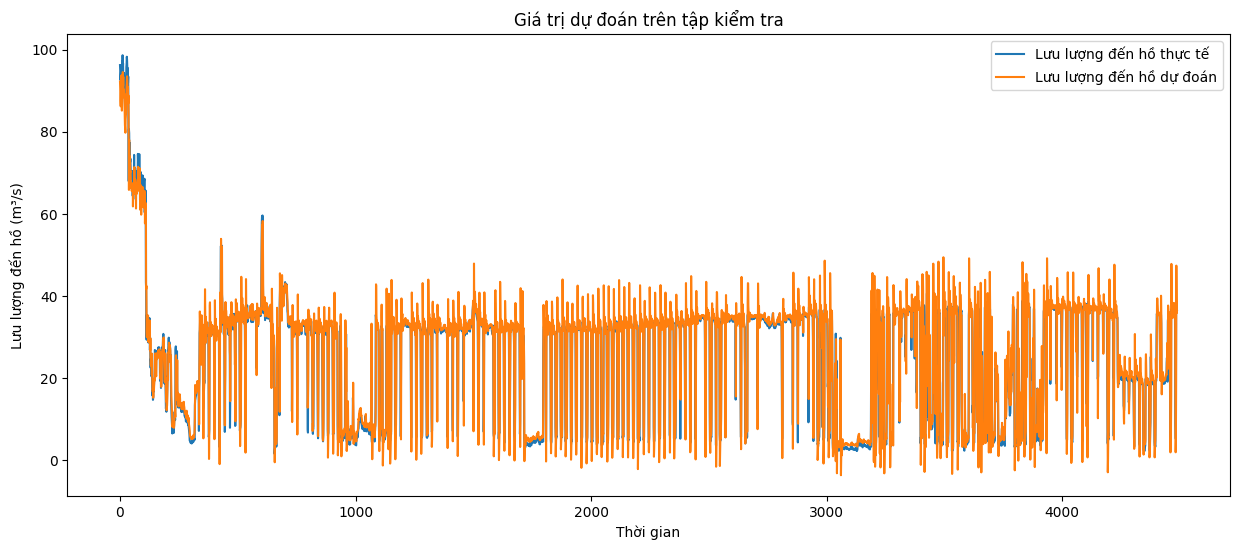


Dữ liệu dự đoán bất thường với dữ liệu cách 2 giờ


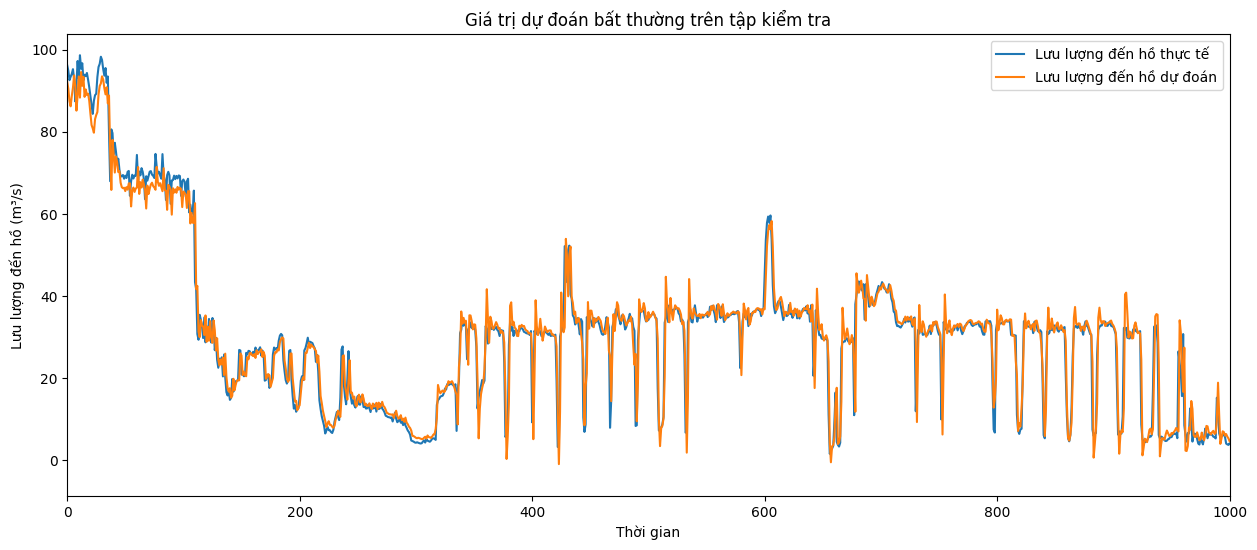

Điểm bất thường trên dữ liệu gốc cách 2 giờ
85/85 [==============================] - 0s 3ms/step


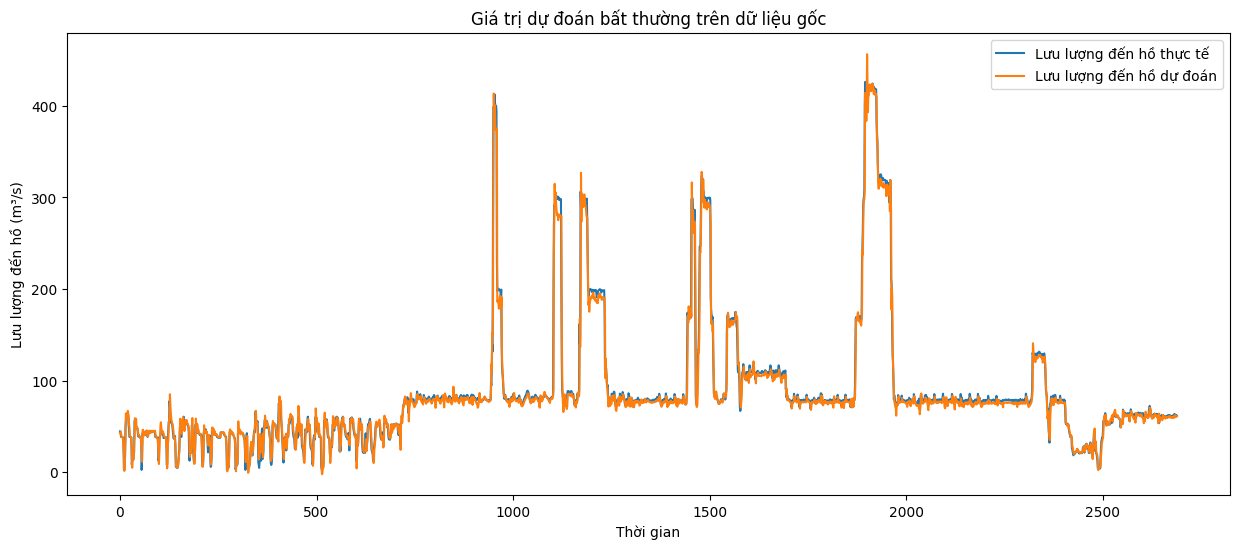

In [ ]:
# Chuẩn hóa lại dữ liệu sau để vẽ mô hình
# y_pred_predict_t_2, y_test_t_2 = inverse_transform_data(scaler_t_2, y_pred_t_2, y_test_t_2)
# y_pred_predict_t_4, y_test_t_4 = inverse_transform_data(scaler_t_4, y_pred_t_4, y_test_t_4)
# y_pred_predict_t_6, y_test_t_6 = inverse_transform_data(scaler_t_6, y_pred_t_6, y_test_t_6)
y_pred_predict_t_8, y_test_t_8 = inverse_transform_data(scaler_t_8, y_pred_t_8, y_test_t_8)

# Vẽ các hình data gốc
# print("Dữ liệu gốc cách 2 giờ")
# plot_data_goc(df_t_2)
# print()
# print("Dữ liệu gốc cách 4 giờ")
# plot_data_goc(df_t_4)
# print()
# print("Dữ liệu gốc cách 6 giờ")
# plot_data_goc(df_t_6)
# print()
# print("Dữ liệu gốc cách 8 giờ")
# plot_data_goc(df_t_8)
# print()

# Biểu đồ giá trị dự đoán và thực tế trên tập test
# print("Dữ liệu dự đoán với dữ liệu cách 2 giờ")
# plot_data_predict(y_test_t_2, y_pred_predict_t_2)
# print()
# print("Dữ liệu dự đoán với dữ liệu cách 4 giờ")
# plot_data_predict(y_test_t_4, y_pred_predict_t_4)
# print()
# print("Dữ liệu dự đoán với dữ liệu cách 6 giờ")
# plot_data_predict(y_test_t_6, y_pred_predict_t_6)
# print()
print("Dữ liệu dự đoán với dữ liệu cách 8 giờ")
plot_data_predict(y_test_t_8, y_pred_predict_t_8)
print()

# Biểu đồ giá trị dự đoán và giá trị thực tế ở điểm bất thường trên tập test
# print("Dữ liệu dự đoán bất thường với dữ liệu cách 2 giờ")
# plot_bat_thuong_test(y_test_t_2, y_pred_predict_t_2)
# print()
# print("Dữ liệu dự đoán bất thường với dữ liệu cách 4 giờ")
# plot_bat_thuong_test(y_test_t_4, y_pred_predict_t_4)
# print()
# print("Dữ liệu dự đoán bất thường với dữ liệu cách 6 giờ")
# plot_bat_thuong_test(y_test_t_6, y_pred_predict_t_6)
# print()
print("Dữ liệu dự đoán bất thường với dữ liệu cách 8 giờ")
plot_bat_thuong_test(y_test_t_8, y_pred_predict_t_8)
print()

# Vẽ biểu đồ tại điểm bất thường trên dữ liệu gốc
# print("Điểm bất thường trên dữ liệu gốc cách 2 giờ")
# plot_data_chi_dinh(scaler_t_2, model_t_2, X_train_t_2, y_train_t_2)
# print()
# print("Điểm bất thường trên dữ liệu gốc cách 4 giờ")
# plot_data_chi_dinh(scaler_t_4, model_t_4, X_train_t_4, y_train_t_4)
# print()
# print("Điểm bất thường trên dữ liệu gốc cách 6 giờ")
# plot_data_chi_dinh(scaler_t_6, model_t_6, X_train_t_6, y_train_t_6)
# print()
print("Điểm bất thường trên dữ liệu gốc cách 8 giờ")
plot_data_chi_dinh(scaler_t_8, model_t_8, X_train_t_8, y_train_t_8)